Part 3: A/B testing using Machine Learning

Preprocessing and Feature Engineering

In this section we will
take the subset of the data to be modelled
encode categorical variables into numeric variables
check the correlation between variables
scale the variable
check for missing values

In [97]:
%matplotlib inline
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split



## Data visualization

In [98]:
data = pd.read_csv("/Users/bez/desktop/10xAc/week2_Adcampaign/data/AdsmartABdata.csv")
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [99]:
for col in data.columns:
  print(col,':', data[col].nunique(), 'labels')

auction_id : 8077 labels
experiment : 2 labels
date : 8 labels
hour : 24 labels
device_make : 270 labels
platform_os : 3 labels
browser : 15 labels
yes : 2 labels
no : 2 labels


# Feature engineering

In [100]:
#Drop auction_id since it is unique to every data and no prediction value
data.drop('auction_id', axis=1, inplace=True)

In [101]:
#Merge yes and no columns into converted(0 for no/1 for yes)
a =pd.DataFrame(data[(data['yes']==1)]) 
b =pd.DataFrame(data[(data['no']==1)])
b['no']=0
df = pd.concat([a, b]).sort_index()
df. drop(['no'], axis=1, inplace=True)
df.rename(columns = {'yes':'converted'}, inplace = True) 
df.head()

,experiment,date,hour,device_make,platform_os,browser,converted
2,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0
16,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1
20,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0
23,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1
27,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0


In [102]:
from sklearn import preprocessing 
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
# Encode labels in all columns. 
df['experiment']= label_encoder.fit_transform(df['experiment'])
df['date']= label_encoder.fit_transform(df['date'])
df['device_make']= label_encoder.fit_transform(df['device_make'])
df['browser']= label_encoder.fit_transform(df['browser'])
df.head()

,experiment,date,hour,device_make,platform_os,browser,converted
2,1,2,2,4,6,2,0
16,1,1,16,13,6,1,1
20,1,3,8,13,6,1,0
23,0,5,4,43,6,4,1
27,0,0,15,13,6,1,0


In [103]:
#Number of unique values for aech column
for col in df.columns:
  print(col,':', df[col].nunique(), 'labels')

experiment : 2 labels
date : 8 labels
hour : 24 labels
device_make : 115 labels
platform_os : 2 labels
browser : 8 labels
converted : 2 labels


In [104]:
#Drop device_make
data.drop('device_make', axis=1, inplace=True)

In [105]:
#standardize the data so that exaggerated values don't affect our model(logistic regression)
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
df[:1243] = scaling.fit_transform(df[:1243])

In [65]:
df.head()

,experiment,date,hour,device_make,platform_os,browser,converted
2,1.0,0.285714,0.086957,0.035088,1.0,0.285714,0.0
16,1.0,0.142857,0.695652,0.114035,1.0,0.142857,1.0
20,1.0,0.428571,0.347826,0.114035,1.0,0.142857,0.0
23,0.0,0.714286,0.173913,0.377193,1.0,0.571429,1.0
27,0.0,0.000000,0.652174,0.114035,1.0,0.142857,0.0


## Splitting data

In [106]:
#split data into 70% training, 20% validation and 10% test data
train, validate, test = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])

In [107]:
#specify the features and target variable for train set
x_train = train[['experiment', 'date', 'hour',  'platform_os', 'browser']]
y_train = train['converted']

#specify the features and target variable for validation data
x_validate = validate[['experiment', 'date', 'hour', 'platform_os', 'browser']]
y_validate = validate['converted']

#specify the features and target variable for test data
x_test = test[['experiment', 'date', 'hour', 'platform_os', 'browser']]
y_test = test['converted']

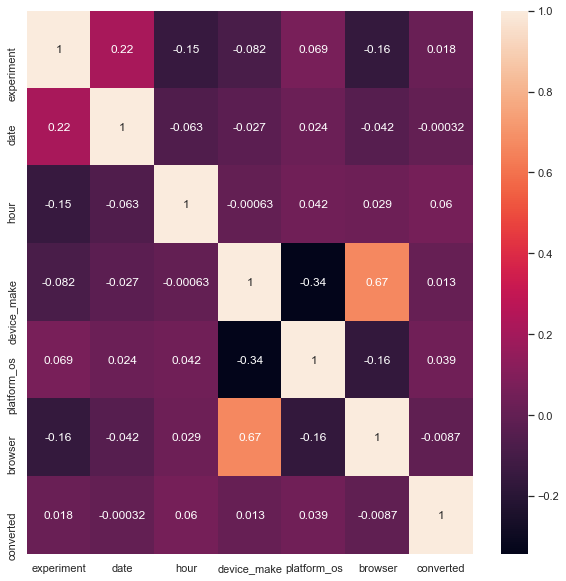

In [108]:
#correlation among the features
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g = sns.heatmap(df[top_corr_features].corr(), annot= True)

## Modeling

In [109]:
#Import modeling algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn import metrics
 



In [115]:
#import cross_validation library
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, random_state=0)

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

## Logistic regression

In [111]:
#train logistic regression mode
log_model = LogisticRegression()
log_model.fit(x_train,y_train)
#calculate average accuracy score 
print(cross_val_score(log_model, x_train, y_train,cv=k_fold, scoring= 'accuracy').mean())

NameError: name 'k_fold' is not defined

In [112]:
#import log_loss
from sklearn.metrics import log_loss
model = log_model
# predict probabilities
probs = model.predict_proba(x_validate)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss using validation data
loss = log_loss(y_validate, probs)
loss

0.6880387086160504

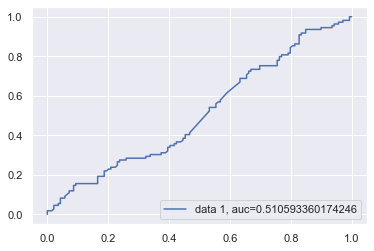

In [113]:
y_pred_proba = log_model.predict_proba(x_validate)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_validate,  y_pred_proba)
auc = metrics.roc_auc_score(y_validate, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [28]:
#predict values using testing data
prediction = log_model.predict(x_test)
predicted_values = pd.DataFrame({
           "experiment" : test['experiment'],
           "converted" : prediction})

In [29]:
predicted_values.head()

,experiment,converted
6002,0.0,0.0
4735,0.0,0.0
4016,0.0,1.0
356,0.0,0.0
7856,0.0,0.0


In [30]:
#confusion matris
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, prediction)
cnf_matrix

array([[56, 15],
       [42, 12]])

## Decision tree

In [31]:
#train decision tree model
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
print(cross_val_score(dt, x_train, y_train,cv= 5, scoring= 'accuracy').mean())

0.47816091954022993


In [32]:
from sklearn.metrics import log_loss
model = dt
# predict probabilities
probs = model.predict_proba(x_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(y_test, probs)
loss

12.705717622410745

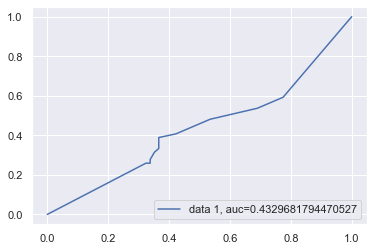

In [33]:
y_pred_proba = dt.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

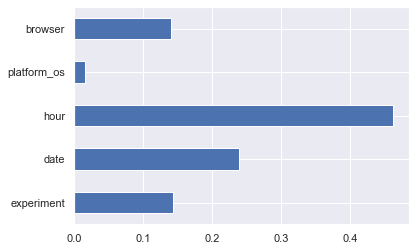

In [34]:
#feature importance
feat_importance = pd.Series(dt.feature_importances_, index=x_train.columns)
feat_importance.plot(kind='barh')
plt.show()

In [35]:
#predict using testing data
prediction = dt.predict(x_test)
predicted_values = pd.DataFrame({
           "experiment" : test['experiment'],
           "yes" : prediction})

In [36]:
predicted_values.head()

,experiment,yes
6002,0.0,1.0
4735,0.0,1.0
4016,0.0,1.0
356,0.0,1.0
7856,0.0,0.0


In [37]:
#confusion matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, prediction)
cnf_matrix

array([[41, 30],
       [32, 22]])

## XGBoost

In [40]:
import xgboost as xgb

In [114]:
#train XGBoost 
data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)
xg_reg = xgb.XGBClassifier()
xg_reg.fit(x_train,y_train)
#calculate average accuracy 
print(cross_val_score(xg_reg, x_train, y_train,cv= 5, scoring= 'accuracy').mean())

/Users/bez/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:47:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bez/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/bez/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:47:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:47:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bez/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/bez/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:47:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:47:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bez/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:47:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4988505747126436


In [39]:
from sklearn.metrics import log_loss
model = xg_reg
# predict probabilities
probs = model.predict_proba(x_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(y_test, probs)
loss

0.9402274233698845

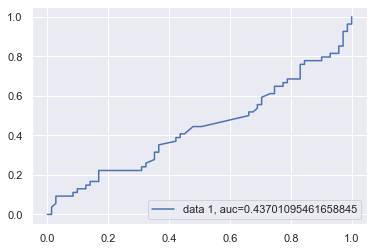

In [42]:
y_pred_proba = xg_reg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

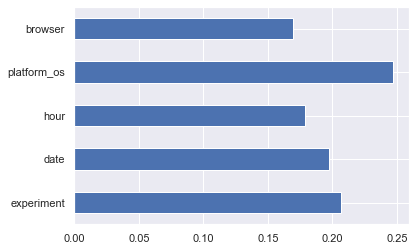

In [43]:
#feature importance for XGBoost model
feat_importance = pd.Series(xg_reg.feature_importances_, index=x_train.columns)
feat_importance.plot(kind='barh')
plt.show()

In [44]:
#predict using testind data
prediction = xg_reg.predict(x_test)
submission = pd.DataFrame({
    "experiment" : test['experiment'],
    "converted" : prediction
})

In [45]:
submission.head()

,experiment,converted
6002,0.0,1.0
4735,0.0,1.0
4016,0.0,1.0
356,0.0,1.0
7856,0.0,0.0


In [46]:
#confusion matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, prediction)
cnf_matrix

array([[41, 30],
       [33, 21]])